# Turkish News Category Classification (3. TRAIN)
## Import Packages

In [3]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [9]:
#  load word and char tfidf vectors
PATH_ROOT = r'../' 

#  load dataset
def load_data(path):
    with open(PATH_ROOT + path, 'rb') as handle:
        dataset = pickle.load(handle)
    return dataset

## Load Word&Char TF-IDF Vectors

In [5]:
with open(PATH_ROOT + 'vectors/interpress_news_category_tr_lite_train_cleaned_tfidf_word_2000.pkl', 'rb') as handle:
    word_tfidf = pickle.load(handle)

with open(PATH_ROOT + 'vectors/interpress_news_category_tr_lite_train_cleaned_tfidf_char_2000.pkl', 'rb') as handle:
    char_tfidf = pickle.load(handle)

## Load Cleaned Train&Test Dataset

In [10]:
df_train = load_data(r"datasets/interpress_news_category_tr_lite_train_cleaned.pkl")
df_test = load_data(r"datasets/interpress_news_category_tr_lite_test_cleaned.pkl")

## TF-IDF Transform Word&Char

In [12]:
train_tf_word_transformed = word_tfidf.transform(df_train['clean_content'])
train_tf_char_transformed = char_tfidf.transform(df_train['clean_content'])

test_tf_word_transformed = word_tfidf.transform(df_test['clean_content'])
test_tf_char_transformed = char_tfidf.transform(df_test['clean_content'])

tf_train_features = hstack([train_tf_word_transformed, train_tf_char_transformed])
tf_train_features.shape

(218880, 4000)

## TRAIN - SVM

In [14]:
#  train SVM model
clf = svm.SVC(kernel='linear', gamma='auto')
clf.fit(tf_train_features, df_train['category'])

#  save model
filename = PATH_ROOT + 'models/interpress_news_category_tr_lite_classifier_svm_model_4000.sav'
pickle.dump(clf, open(filename, 'wb'))

## Score ACC - TEST

In [15]:
#  stack word and char tfidf features for train
tf_test_featured = hstack([test_tf_word_transformed, test_tf_char_transformed])

#  get accuracy
clf.score(tf_test_featured, df_test['category'])

0.9366239652053142

## Model evaluation

In [18]:
#  get predictions and actual labels
y_pred = []
y_true = []

for i, news in enumerate(tqdm(df_test['clean_content'])):
    word_transformed_news = word_tfidf.transform([news])
    char_transformed_news = char_tfidf.transform([news])
    news_featured = hstack([word_transformed_news, char_transformed_news])
    result = clf.predict(news_featured)[0]
    y_pred.append(result)
    y_true.append(df_test['category'].iloc[i])


100%|██████████| 54721/54721 [12:35:47<00:00,  1.21it/s]  


## Classification Report

In [19]:
#  show classification report
labels = ["Kültür-Sanat","Ekonomi","Siyaset","Eğitim","Dünya","Spor","Teknoloji","Magazin","Sağlık","Gündem"]

print(classification_report(y_true, y_pred, target_names=labels))

              precision    recall  f1-score   support

Kültür-Sanat       0.92      0.96      0.94     17491
     Ekonomi       0.94      0.94      0.94      9086
     Siyaset       0.92      0.87      0.89      2448
      Eğitim       0.90      0.90      0.90      2597
       Dünya       0.89      0.80      0.84      1816
        Spor       0.98      0.97      0.98      5975
   Teknoloji       0.95      0.95      0.95      7928
     Magazin       0.91      0.83      0.87      1461
      Sağlık       0.95      0.92      0.94      4766
      Gündem       0.97      0.92      0.95      1153

    accuracy                           0.94     54721
   macro avg       0.93      0.91      0.92     54721
weighted avg       0.94      0.94      0.94     54721



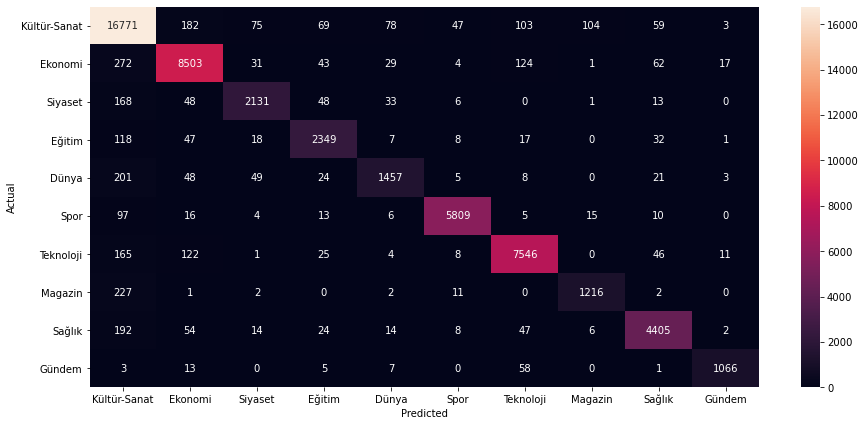

In [20]:
#  visualize confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()